In [1]:
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.svm
import sklearn as sk
import pandas as pd
import numpy as np
import time
import nltk
import nltk.corpus

def load_region_data(region: str, language: str) -> pd.DataFrame:
    parquet_filename = os.path.join('./archive','{}-{}.parquet.gz'.format(region, language))
    if os.path.exists(parquet_filename):
        df = pd.read_parquet(parquet_filename)
        return df, df['category_id'].nunique()
    
    df = pd.read_csv('./archive/{}videos.csv'.format(region))

    # Drop unused columns
    df = df.drop(['thumbnail_link', 'video_id'], axis=1)
    df = df.dropna()

    # Enrich data
    df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
    df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
    df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
    df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
    df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
    df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
    df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)
    df['morning_video'] = df['publish_hour'].apply(lambda t: 1 if t <= 12 else 0)
    
    df = df.dropna()

    # Transform category_id to label
    category_le = sk.preprocessing.LabelEncoder()
    category_le.fit(df['category_id'])
    df['category_id'] = category_le.transform(df['category_id'])

    # Load stopwords
    try:
        stop_words = set(nltk.corpus.stopwords.words(language))
    except Exception:
        nltk.download('stopwords')
        stop_words = set(nltk.corpus.stopwords.words(language))
    
    # Drop stopwords
    df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    
    views = df['views'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.PowerTransformer()
    df['views'] = view_scaler.fit_transform(views)
    
    likes = df['likes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['likes'] = view_scaler.fit_transform(likes)
    
    dislikes = df['dislikes'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['dislikes'] = view_scaler.fit_transform(dislikes)
    
    df.to_parquet(parquet_filename, compression='gzip')
    
    return df, len(category_le.classes_)

df, num_classes = load_region_data('US', 'english')
df.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_hour,like_dislike,anti_participation,morning_video
index,,,,,,,,,,,,,,,,,,
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,7,2017-11-13T17:13:01.000Z,SHANtell martin,0.050373,-0.075659,-0.023983,15954,0,0,0,SHANTELL'S CHANNEL - https://www.youtube.com/s...,17,0.950970,0,0
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,9,2017-11-13T07:30:00.000Z,last week tonight trump presidency last week t...,0.783839,0.096731,0.112953,12703,0,0,0,"One year presidential election, John Oliver di...",7,0.940521,0,1
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,8,2017-11-12T19:05:24.000Z,racist superman rudy mancuso king bach racist ...,0.964862,0.309069,0.078202,8181,0,0,0,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,19,0.964729,0,0
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,9,2017-11-13T11:00:04.000Z,rhett link gmm good mythical morning rhett lin...,-0.409199,-0.281508,-0.123026,2146,0,0,0,Today find Link Nickelback amateur secret Nick...,11,0.938550,0,1
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,9,2017-11-12T18:01:41.000Z,ryan higa higatv nigahiga dare idy rhpc dares ...,0.691400,0.249091,-0.066055,17518,0,0,0,"I know since show, we're back might best episo...",18,0.985181,0,0


In [2]:
X = df[['category_id', 'like_dislike', 'views']].to_numpy()
Y = df[['morning_video']].to_numpy()

xtr, xts, ytr, yts = sk.model_selection.train_test_split(X, Y, shuffle=True, test_size=0.33)

[Text(0.5, 0, 'category'), Text(0.5, 0, 'views'), Text(0.5, 0, 'like_dislike')]

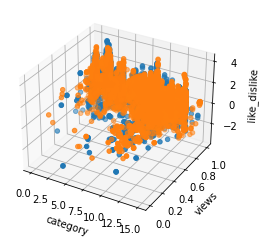

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
%matplotlib inline

tests = pd.DataFrame(data=np.hstack([xts, yts]), columns=['category_id', 'like_dislike', 'views', 'actual'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for color, pred, marker in [('red', 1, 'x'), ('blue', 0, 'o')]:
    _x = tests[tests['actual'] == pred].to_numpy()
    ax.scatter(_x[:, 0], _x[:, 1], _x[:, 2])
ax.set(xlabel='category', ylabel='views', zlabel='like_dislike')


In [4]:
clf = sk.model_selection.GridSearchCV(
    estimator=sk.svm.SVC(),
    param_grid={'C': [1, 10], 'kernel': ['poly', 'rbf'], 'gamma': [0.01, 0.001]},
    n_jobs=20,
    verbose=5,
    cv=5
)
train_start = time.time()
clf.fit(xtr, ytr)
print('train time: {:2f}mins'.format((time.time() - train_start) / 60.))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 out of  40 | elapsed:    7.5s remaining:   22.5s
[Parallel(n_jobs=20)]: Done  19 out of  40 | elapsed:   11.7s remaining:   12.9s
[Parallel(n_jobs=20)]: Done  28 out of  40 | elapsed:   16.6s remaining:    7.1s
[Parallel(n_jobs=20)]: Done  37 out of  40 | elapsed:   45.4s remaining:    3.7s
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:   49.9s finished
/home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


train time: 1.040956mins


In [5]:
clf.score(xts, yts)

0.6848293013791544

In [6]:
import pickle
with open('model-svm.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [7]:
results = pd.DataFrame(clf.cv_results_)[['param_C', 'param_kernel', 'mean_test_score']]
results.head(20)

,param_C,param_kernel,mean_test_score
0,1,poly,0.691017
1,1,rbf,0.691017
2,1,poly,0.691017
3,1,rbf,0.691017
4,10,poly,0.691017
5,10,rbf,0.691017
6,10,poly,0.691017
7,10,rbf,0.691017
